# DMRG

In this notebook we will study the ground state of a spin Hamiltonian
$$H = \sum_{i=1}^N \sigma^z_i \sigma^z_i + h \sum_i \sigma^x_i$$
using matrix product states and the density matrix renormalization group algorithm (DMRG in short).

First, we assume the SeeMPS library has been installed in the environment, and import a set of tools.

In [1]:
from seemps.hamiltonians import ConstantTIHamiltonian
from seemps.optimization import dmrg
from seemps.state import MPS, product_state
import numpy as np

Next, we define our operators. The `ConstantTIHamiltonian` class is a tool to construct matrix product operators for a given problem. It allows you to define the interaction between nearest-neighbor sites and some local terms, and move ahead.

In [2]:
N = 10
h = 0.2
sx = np.array([[0, 1], [1, 0]])
sz = np.array([[1, 0], [0, -1]])
H = ConstantTIHamiltonian(size=N, interaction=np.kron(sz, sz), local_term=h * sx)

We use the DMRG algorithm with a suitable guess to find out the ground state energy

In [3]:
result = dmrg(H, guess=product_state(np.ones(2) / np.sqrt(2), N))
print(f"DMRG energy = {result.energy}")

DMRG energy = -9.100252539845783


We can compare with the exact diagonalization, because the problem is small

In [4]:
from scipy.sparse.linalg import eigsh

E, _ = eigsh(H.to_matrix(), k=1, which="SA")
print(f"Exact energy = {result.energy}")

Exact energy = -9.100252539845783


With this, we can do a slightly more sophisticated study of the quantum phase transition.

Energy = -14.000000, time = 0.109375s, errors: E = 5.329071e-15, Sz = 7.105427e-15, Sx = -6.446965e-18
Energy = -14.037523, time = 0.296875s, errors: E = 2.664535e-14, Sz = -1.207923e-13, Sx = 3.830269e-14
Energy = -14.150379, time = 0.234375s, errors: E = 3.197442e-14, Sz = 4.973799e-14, Sx = 2.620126e-14
Energy = -14.339443, time = 0.250000s, errors: E = 1.243450e-14, Sz = 3.996803e-13, Sx = 1.318501e-12
Energy = -14.606256, time = 0.312500s, errors: E = 1.776357e-14, Sz = 1.225686e-13, Sx = 2.149392e-13
Energy = -14.953166, time = 0.328125s, errors: E = 5.506706e-14, Sz = 5.631051e-13, Sx = 1.294076e-12
Energy = -15.383579, time = 0.375000s, errors: E = 0.000000e+00, Sz = 2.143352e-11, Sx = 3.561507e-11
Energy = -15.902429, time = 0.390625s, errors: E = 1.065814e-13, Sz = 9.749535e-11, Sx = 1.394529e-10
Energy = -16.517102, time = 0.468750s, errors: E = 3.552714e-14, Sz = 3.090861e-13, Sx = 4.565237e-13
Energy = -17.238942, time = 0.406250s, errors: E = 4.618528e-14, Sz = 3.836931e-

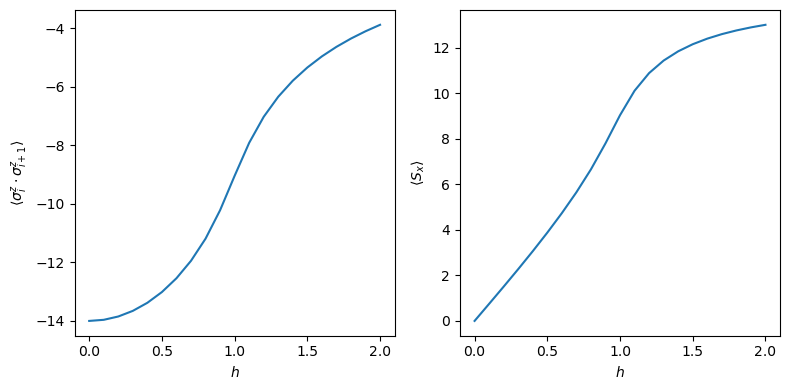

In [5]:
import matplotlib.pyplot as plt
from time import process_time



def experiment_00(N: int = 30, steps: int = 21):
    """Explore the quantum phase transition as a function of the transverse
    magnetic field $h$. Plots the magnetizations of the ground state, computed
    with a small symmetry breaking term."""
    h = np.linspace(0, 2, steps)
    epsilon = 0
    sx = np.array([[0, 1], [1, 0]])
    sz = np.array([[1, 0], [0, -1]])
    sz_values = []
    sx_values = []
    extras = ""

    ZZ = ConstantTIHamiltonian(size=N, interaction=np.kron(sz, sz))
    X = ConstantTIHamiltonian(size=N, local_term=sx)
    for hi in h:
        H = ConstantTIHamiltonian(
            size=N, interaction=np.kron(sz, sz), local_term=-hi * sx + epsilon * sz
        )
        time = process_time()
        result = dmrg(H, guess=product_state(np.ones(2) / np.sqrt(2), N), maxiter=100)
        time = process_time() - time
        sz_values.append(ZZ.to_mpo().expectation(result.state))
        sx_values.append(X.to_mpo().expectation(result.state))

        if N <= 20:
            E, psi0 = eigsh(H.to_matrix(), v0=result.state.to_vector(), k=1, which="SA")
            E = E[0]
            psi0 = psi0[:, 0]
            sz_exact = np.vdot(psi0, ZZ.to_matrix() @ psi0)
            sx_exact = np.vdot(psi0, X.to_matrix() @ psi0)
            extras = (
                f", errors: E = {abs(E - result.energy):6e}, "
                f"Sz = {sz_exact - sz_values[-1]:6e}, "
                f"Sx = {sx_exact - sx_values[-1]:6e}"
            )
        print(f"Energy = {result.energy:+6f}, time = {time:5f}s" + extras)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))
    ax1.plot(h, sz_values)
    ax1.set_xlabel(r"$h$")
    ax1.set_ylabel(r"$\langle{\sigma^z_{i}\cdot \sigma^z_{i+1}}\rangle$")
    ax2.plot(h, sx_values)
    ax2.set_xlabel(r"$h$")
    ax2.set_ylabel(r"$\langle{S_x}\rangle$")
    fig.tight_layout()



experiment_00(N=15)

Energy = -29.000000, time = 0.265625s
Energy = -29.033343, time = 0.484375s
Energy = -29.133482, time = 0.500000s
Energy = -29.300758, time = 0.546875s
Energy = -29.535747, time = 0.515625s
Energy = -29.839289, time = 0.484375s
Energy = -30.212513, time = 0.718750s
Energy = -30.656891, time = 0.718750s
Energy = -31.174306, time = 0.781250s
Energy = -31.767158, time = 0.687500s
Energy = -32.438524, time = 0.750000s
Energy = -33.192426, time = 0.921875s
Energy = -34.034285, time = 1.062500s
Energy = -34.971833, time = 1.125000s
Energy = -36.017132, time = 1.328125s
Energy = -37.188459, time = 1.421875s
Energy = -38.492202, time = 1.406250s
Energy = -39.901845, time = 1.125000s
Energy = -41.388578, time = 0.968750s
Energy = -42.933963, time = 1.171875s
Energy = -44.525857, time = 1.000000s
Energy = -46.155649, time = 0.921875s
Energy = -47.816927, time = 0.843750s
Energy = -49.504756, time = 0.906250s
Energy = -51.215244, time = 0.875000s
Energy = -52.945263, time = 0.890625s
Energy = -54

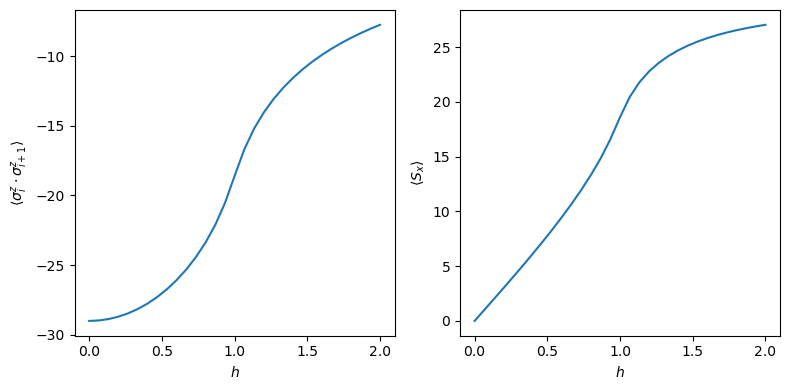

In [6]:
experiment_00(N=30, steps=31)